In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import math

(128, 128, 3)


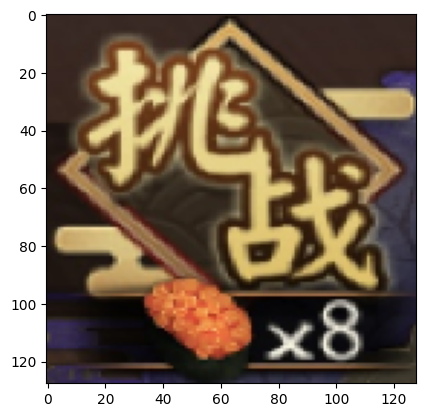

In [4]:
img_t = cv.imread("../pics/03-T.jpg")
img_t = cv.cvtColor(img_t, cv.COLOR_BGR2RGB)
img_t = cv.resize(img_t, [128, 128])
# img_t = cv.resize(img_t, [256, 256])
print(img_t.shape)
plt.imshow(img_t)

In [5]:
def gen_down_sample(I, levels=6):
    '''
    Generate down sample images for input images
    
    '''
    G = I.copy()
    pI = [G]
    for i in range(levels):
        G = G[::2,::2,:]
        pI.append(G)
    return pI

In [6]:
def make_square(I):
    '''
    This function is used to construct a rectangular images to be used in generate gaussian pyramid

    The return value are the square shaped image and the max level can be used to generate gaussian pyramid
    '''
    h = I.shape[0]
    w = I.shape[1]
    
    n_levels = int(np.ceil(np.log(np.max([h,w]))/np.log(2)))
    new_h = np.power(2, n_levels)
    new_w = new_h
    
    if len(I.shape) == 3:
        tmp = np.zeros([new_h, new_w, I.shape[2]], dtype=I.dtype)
        tmp[:h,:w,:] = I
    else:
        tmp = np.zeros([new_h, new_w], dtype=I.dtype)
        tmp[:h,:w] = I

    return tmp, n_levels

In [14]:
def gen_gaussian_pyramid(I, levels):
    '''
    This function is used to generate gaussian pyramid
    The return value is a list contains different levels gaussian pyramid
    '''
    G = I.copy()
    gpI = [G]
    for i in range(levels):
        G = cv.pyrDown(G)
        gpI.append(G)
    return gpI

In [10]:
sq_img, levels = make_square(img_t)
ds_list = gen_down_sample(sq_img, levels-3)

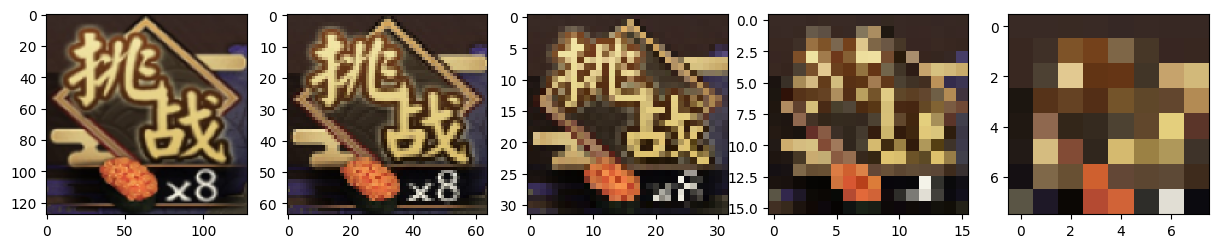

In [11]:
fig, axs = plt.subplots(1, len(ds_list), figsize=(15,5))
for idx, ax in enumerate(axs):
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.imshow(ds_list[idx],cmap="gray")

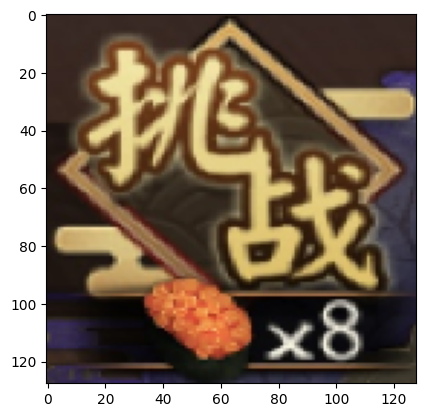

In [12]:
plt.imshow(ds_list[0])

In [17]:
sq_128, nlevel= make_square(ds_list[0])

gpi = gen_gaussian_pyramid(sq_128, nlevel-3)

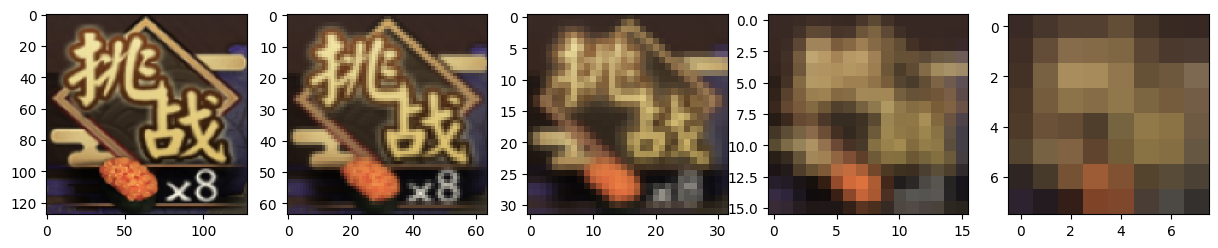

In [18]:
fig, axs = plt.subplots(1, len(gpi), figsize=(15,5))
for idx, ax in enumerate(axs):
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.imshow(gpi[idx],cmap="gray")